In [2]:
import numpy as np
import tqdm
import sklearn.metrics
import json
import pickle
import pandas as pd
import torch
import cv2
from pathlib import Path
from collections import Counter
from pprint import pprint
import matplotlib.pyplot as plt

from torchmetrics.functional import auroc

ModuleNotFoundError: No module named 'torchmetrics'

In [3]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 398.2/398.2 KB 3.2 MB/s eta 0:00:0000:01


In [4]:
RESAMPLE_FAILED_WARNING = "Resampling distrubution for estimator {} failed because of : {}"
CONFIDENCE_INTERVAL_EXCEPTION = "Cannot calculate confidence interval. Sampled {} times for found {} (target {}) valid samples."

def ci_bounds(mean, deltas, confidence_interval, num_resamples):
    '''
    Returns the lower and upper bounds of the confidence interval.
    mean : the empirical mean
    deltas : deltas from the empirical mean from different samples
    '''
    deltas = np.sort(deltas)
    index_offset = int((1 - confidence_interval)/2. * num_resamples)
    lower_delta, upper_delta = deltas[index_offset], deltas[-index_offset]
    lower_bound, upper_bound = mean - upper_delta, mean - lower_delta
    return lower_bound, upper_bound


def confidence_interval(confidence_interval, num_resamples, emperical_distribution, estimator=np.mean, clusters=None):
    '''
    Estimates confidence interval of the mean of emperical_distribution
    using emperical bootstrap. Method details are available at:
    https://ocw.mit.edu/courses/mathematics/18-05-introduction-to-probability-and-statistics-spring-2014/readings/MIT18_05S14_Reading24.pdf
    -confidence_interval: Amount of probability mass interval should cover.
    -num_resamples: Amount of trails to use to estimate confidence interval.
    Should as large as computationally feasiable.
    -emperical_distribution: Emperical distributions for which we want to
    estimate the confidence interval of the mean
    if Clusters is not none, perform two stage bootstrap.
    '''

    emp_mean = estimator(emperical_distribution)
    num_samples = len(emperical_distribution)
    deltas = []
    num_tries = 0
    if clusters is not None:
        cluster_to_inds = {}
        for ind, cluster in enumerate(clusters):
            if cluster not in cluster_to_inds:
                cluster_to_inds[cluster] = []
            cluster_to_inds[cluster].append(ind)
        num_clusters = len(cluster_to_inds)
        cluster_ids = list(cluster_to_inds.keys())

    while len(deltas) < num_resamples:
        if num_tries > num_resamples * 10:
            raise Exception(CONFIDENCE_INTERVAL_EXCEPTION.format(num_tries, len(deltas), num_resamples))
        num_tries += 1
        try:
            if clusters is None:
                resample_ind = np.random.choice(a=range(len(emperical_distribution)),
                                        size=num_samples,
                                        replace=True
                                        )
            else:
                resample_clusters = np.random.choice(a=cluster_ids,
                                                    size=num_clusters,
                                                    replace=True)
                resample_ind = []
                for cluster in resample_clusters:
                    resampled_inds_for_cluster = np.random.choice(a=cluster_to_inds[cluster],
                                                                size=len(cluster_to_inds[cluster]),
                                                                replace=True)
                    resample_ind.extend(resampled_inds_for_cluster)

            resample_dist = [ emperical_distribution[ind] for ind in resample_ind]
            delta = estimator(resample_dist) - emp_mean
            deltas.append( delta )
        except Exception as e:
            warnings.warn(RESAMPLE_FAILED_WARNING.format(estimator, e))

    lower_bound, upper_bound = ci_bounds(emp_mean, deltas, confidence_interval, num_resamples)

    return (lower_bound, upper_bound)

def resample_set_by_distribution(sets, probs, length):
    '''
    Returns a new set by sampling from the given sets with repetitions by the given probs.
    sets : list of sets to sample from
    probs : list of probability for each set (should sum to 1)
    length : length of the new built set
    Returns the new set and an np.array with the set index for each element in the new array.
    '''

    probs_array = np.array([])
    concat_array = np.array([])
    set_inds = np.array([])
    for i, cur_set in enumerate(sets):
        cur_probs = np.ones((len(cur_set))) * probs[i] / len(cur_set)
        probs_array = np.append(probs_array, cur_probs)
        concat_array = np.append(concat_array, cur_set)
        set_inds = np.append(set_inds, np.ones(len(cur_set))*i)

    idx = np.random.choice(np.arange(len(concat_array)), size=length, replace=True, p=probs_array)
    return concat_array[idx], set_inds[idx]

## Load Data

In [9]:
HIDDENS_DIR = '/Mounts/rbg-storage1/users/ludvig/SybilX/hiddens/test_run'
RUN_NAME = 'fd123f28a2fcd6290477d6b12300c0e6'

In [11]:
probs = []
golds = []
preds = []
exams = []
for i, path in enumerate(Path(HIDDENS_DIR, RUN_NAME).glob('*.predictions')):
    #print(path)
    p = pickle.load(open(str(path), 'rb'))
    
    probs.append(p['probs'])
    golds.append(p['golds'])
    preds.append(p['preds'])
    exams.append(p['exam'])

probs = torch.stack(probs)
golds = torch.stack(golds)
preds = torch.stack(preds)
exams = torch.stack(exams)

golds.shape, preds.shape

RuntimeError: stack expects a non-empty TensorList

## Get metadata
### PLCO

In [ ]:
DATASET_PATH = '/Mounts/rbg-storage1/datasets/PLCO_XRAY/metadata_2022_03_05.json'
metadata = json.load(open(DATASET_PATH, 'r'))
exam2pid = {}
exam2split = {}
for p in metadata:
    pid = p['pid']
    for e in p['accessions']:
        study_yr = e['study_yr']
        
        pid_int = int( str(ord(pid[0])) + ''.join(c for c in pid if c.isdigit()) )
        exam_int = int(f"{int(pid_int)}{int(study_yr)}")
        
        exam2pid[exam_int] = pid
        exam2split[exam_int] = p['split']
    
pids = [exam2pid[exam.item()] for exam in exams]

### NLST

In [ ]:
DATASET_PATH = '/Mounts/rbg-storage1/datasets/ACRIN_XRAY/xray_dataset.json'
metadata = json.load(open(DATASET_PATH, 'r'))
exam2pid = {}
for p in metadata:
    pid = p['pid']
    for e in p['accessions']:
        screen_timepoint = e["screen_timepoint"]
        for s in e['image_series']: # seperate examno for each series???
            #study_yr = e['study_yr']
            series_id = s["series_id"]

            exam_int = int(f"{int(pid)}{int(screen_timepoint)}{int(series_id.split('.')[-1][-3:])}")

            exam2pid[exam_int] = pid
    
pids = [exam2pid[exam.item()] for exam in exams]

### create input to CI

In [ ]:
exam2split[exams[0].item()]

In [ ]:
emp_dist = list(zip(probs, golds))
#splits = [exam2split[e.item()] for e in exams]
                
# filter to only test DOESN'T WORK, ONLY USES STATIC SPLITS
#emp_dist_test = [x for i,x in enumerate(emp_dist) if splits[i] == 'test']
#pids_test = [x for i,x in enumerate(pids) if splits[i] == 'test']

#len(emp_dist_test)

## Compute Confidence Interval

In [ ]:
def estimator(ed_tups):
    prob = list(map(lambda x: x[0], ed_tups))
    gold = list(map(lambda x: x[1], ed_tups))
    prob = torch.stack(prob)
    gold = torch.stack(gold)
    
    return auroc(prob, gold, pos_label=1, num_classes=2)


In [ ]:
low, high = confidence_interval(0.95, 5000, emp_dist, estimator, clusters=pids)
np.round(low.item(), 3), np.round(high.item(), 3)

(0.575, 0.65)

### Comparison of ours vs CXR-LC's splits

In [3]:
CXR_LC_PATIENT_SPLITS_FILENAME = ("/Mounts/rbg-storage1/datasets/PLCO_XRAY/patient2split_cxr_lc.pkl")
CXR_LC_IMAGE_SPLITS_FILENAME = ("/Mounts/rbg-storage1/datasets/PLCO_XRAY/image2split_cxr_lc.pkl")

In [40]:
patient_splits = pickle.load(open(CXR_LC_PATIENT_SPLITS_FILENAME, "rb"))
image_splits = pickle.load(open(CXR_LC_IMAGE_SPLITS_FILENAME, "rb"))

In [41]:
PLCO_METADATA_JSON_PATH = "/Mounts/rbg-storage1/datasets/PLCO_XRAY/metadata_2022_03_05.json"
plco_metadata = json.load(open(PLCO_METADATA_JSON_PATH, "r"))

In [ ]:
patient_splits_df = pd.DataFrame

In [61]:
# convert to df
patient_splits_df = pd.DataFrame({'plco_pid': patient_splits.keys(),
                               'split': [list(val)[0] for val in patient_splits.values()]})
image_splits_df = pd.DataFrame({'filename': image_splits.keys(), 'split': image_splits.values()})

In [56]:
df = []
for p in plco_metadata:
    for e in p['accessions']:
        for s in e['image_series']:
            path = Path(s['path'])
            filename = path.name
            pid = p['pid']
            
            
            if pid in patient_splits:
                patient_split = list(patient_splits[pid])[0]
            else:
                patient_split = -1
            
            if filename in image_splits:
                image_split = image_splits[filename]
            else:
                image_split = -1
            
            df.append({
                'pid': p['pid'],
                'filename': filename,
                'patient_split': patient_split,
                'image_split': image_split,
            })
            
df = pd.DataFrame(df)
df

,pid,filename,patient_split,image_split
0,T-083431-8,AI02934081407133557_v2.tif,Te,Te
1,T-083431-8,AI02934081407133916_v2.tif,Te,-1
2,T-083431-8,AI02934081407134032_v2.tif,Te,-1
3,T-083431-8,AI02934081407133724_v2.tif,Te,-1
4,Y-086037-1,AC01367021006152811_v2.tif,Tr,-1
...,...,...,...,...
89711,T-032473-1,AJ06916110206120921_v2.tif,Tr,Tr
89712,U-005771-2,AF0590773107100124_v2.tif,Tu,Tu
89713,N-085998-6,AG06296080907113637_v2.tif,Tu,Tu
89714,G-036878-9,AC01397062306135648_v2.tif,Tu,Tu


In [50]:
# are there any where the patient split and the image split disagree?
((df.patient_split != df.image_split) & (~((df.patient_split == -1) | (df.image_split == -1))) ).any()

False

In [76]:
# number of patients we don't have
(~patient_splits_df.plco_pid.isin(df.pid) ).sum()

0

In [84]:
# number of images we don't have
(~image_splits_df.filename.isin(df.filename)).sum()

52581

In [93]:
# number of images we don't have, broken down by split
print('Tr', (~image_splits_df.loc[image_splits_df.split == 'Tr'].filename.isin(df.filename)).sum() )
print('Tu', (~image_splits_df.loc[image_splits_df.split == 'Tu'].filename.isin(df.filename)).sum() )
print('Te', (~image_splits_df.loc[image_splits_df.split == 'Te'].filename.isin(df.filename)).sum() )

Tr 37357
Tu 9512
Te 5712


In [81]:
# number of patients we have extra
( ~pd.Series(df.pid.unique()).isin(patient_splits_df.plco_pid) ).sum()

1265

In [58]:
Counter(df.groupby('pid').patient_split.first())

Counter({'Tr': 15245, 'Te': 4752, 'Tu': 3738, -1: 1265})

In [85]:
Counter(df.image_split)

Counter({'Te': 4752, -1: 46085, 'Tr': 31168, 'Tu': 7711})

In [88]:
patient_splits_df.plco_pid.nunique()

23735

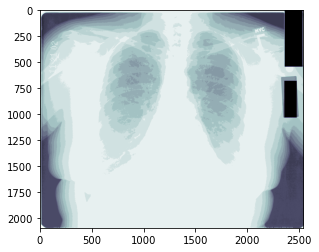

In [211]:
x = json.load(open("/Mounts/rbg-storage1/datasets/PLCO_XRAY/metadata_2022_03_10_rotated.json","r"))
img_path = x[100]['accessions'][0]['image_series'][0]['path']
img = cv2.imread(img_path, 0)
plt.imshow(img, cmap=plt.cm.bone)

In [12]:
import pydicom

In [13]:
img = pydicom.dcmread('/Mounts/rbg-storage1/datasets/ACRIN_XRAY/NLST/2002-01__Studies/ _209191_CR_2002-01-01_100255_CHEST_CHEST_n1__00000/1.3.12.2.1107.5.4.4.01070.5.0.888752031864358.dcm')

In [19]:
img.pixel_array

array([[1564, 1533, 1485, ..., 1458, 1412,    0],
       [1566, 1516, 1477, ..., 1397, 1336,    0],
       [1550, 1510, 1467, ..., 1332, 1272,    0],
       ...,
       [1012, 1006,  998, ...,  971,  898,    0],
       [1014, 1007,  998, ...,  974,  898,    0],
       [1014, 1007, 1003, ...,  973,  898,    0]], dtype=uint16)